**Table of contents**<a id='toc0_'></a>    
- [Importing Libraries](#toc1_)    
- [Configuring Visualization Parameters](#toc2_)    
- [Configuring Other Notebook Parameters](#toc3_)    
- [Pre-installing Custom Functions](#toc4_)    
- [Practicing in Stages](#toc5_)    
  - [Preprocessing](#toc5_1_)    
    - [Preprocessing of Training Set Labels](#toc5_1_1_)    
    - [Reading and Effective Storage of DICOM Files](#toc5_1_2_)    
  - [Train - Part One - Data Loading](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Importing Libraries](#toc0_)


In [1]:
import pydicom

In [2]:
# import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
# from torchvision.utils import make_grid

In [3]:
import matplotlib as mpl

# import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [4]:
import cv2

# from datetime import datetime
# from functools import wraps

# import itertools
# import math
from pathlib import Path

# import random
import reprlib

# from scipy import ndimage
import sys
from tqdm.notebook import tqdm

# <a id='toc2_'></a>[Configuring Visualization Parameters](#toc0_)


In [5]:
%matplotlib inline

In [6]:
XINHUI = "#7a7374"
XUEBAI = "#fffef9"
YINBAI = "#f1f0ed"
YINHUI = "#918072"

figure_size = (16, 9)

In [7]:
custom_params = {
    "axes.axisbelow": True,
    "axes.edgecolor": YINBAI,
    "axes.facecolor": XUEBAI,
    "axes.grid": True,
    "axes.labelcolor": XINHUI,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlecolor": XINHUI,
    "figure.edgecolor": YINBAI,
    "figure.facecolor": XUEBAI,
    "grid.alpha": 0.8,
    "grid.color": YINBAI,
    "grid.linestyle": "--",
    "grid.linewidth": 1.2,
    "legend.edgecolor": YINHUI,
    "patch.edgecolor": XUEBAI,
    "patch.force_edgecolor": True,
    "text.color": XINHUI,
    "xtick.color": YINHUI,
    "ytick.color": YINHUI,
}

mpl.rcParams.update(custom_params)

# <a id='toc3_'></a>[Configuring Other Notebook Parameters](#toc0_)


In [8]:
reprlib_rules = reprlib.Repr()
reprlib_rules.maxother = 250

# <a id='toc4_'></a>[Pre-installing Custom Functions](#toc0_)


In [9]:
sys.path.append("../")

In [10]:
from Modules import *

# <a id='toc5_'></a>[Practicing in Stages](#toc0_)

## <a id='toc5_1_'></a>[Preprocessing](#toc0_)

### <a id='toc5_1_1_'></a>[Preprocessing of Training Set Labels](#toc0_)


In [11]:
# The datasets used in this practice project are a subset of the publicly available chest X-ray
# datasets (https://nihcc.app.box.com/v/ChestXray-NIHCC) from the National Institutes of Health
# (NIH) Clinical Center (https://clinicalcenter.nih.gov/), and the related NIH press release
# can be found at the following link:
# https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest
# -publicly-available-chest-x-ray-datasets-scientific-community

# References:
# [1] X. Wang, Y. Peng, L. Lu, Z. Lu, M. Bagheri and R. M. Summers, "ChestX-Ray8:
# Hospital-Scale Chest X-Ray Database and Benchmarks on Weakly-Supervised Classification and
# Localization of Common Thorax Diseases," 2017 IEEE Conference on Computer Vision and Pattern
# Recognition (CVPR), Honolulu, HI, USA, 2017, pp. 3462-3471, doi: 10.1109/CVPR.2017.369.

# This article is publicly available through the following links, among others:
# http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest
# _CVPR_2017_paper.pdf or https://arxiv.org/pdf/1705.02315.pdf

# The dataset, provided by Kaggel Datasets, is called RSNA Pneumonia Detection Challenge
# (https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge) and was developed
# in collaboration with the Radiological Society of North America (RSNA®), the US National
# Institutes of Health, the Society of Thoracic Radiology, and MD.ai
original_labels = pd.read_csv(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_labels.csv"
)

# Positive targets indicated that these subjects suffered from pneumonia, with more
# positive targets indicating a more significant condition
grouped_labels = pd.DataFrame(
    original_labels.groupby(["patientId"])["Target"].sum()
).reset_index()

most_tagged_IDs = grouped_labels.loc[
    grouped_labels["Target"] == grouped_labels["Target"].max()
]

dataframe_1 = DataFrame_Generator(original_labels.columns.to_list())
for i in range(10):
    dataframe_1.updater(original_labels.iloc[i].to_list())

dataframe_2 = DataFrame_Generator(grouped_labels.columns.to_list())
for i in range(10):
    dataframe_2.updater(grouped_labels.iloc[i].to_list())

dataframe_3 = DataFrame_Generator(most_tagged_IDs.columns.to_list())
for i in range(len(most_tagged_IDs)):
    dataframe_3.updater(most_tagged_IDs.iloc[i].to_list())

tabulation = Form_Generator()
tabulation.heading_printer("Reading of training set labels")

statements = [
    """
original_labels = pd.read_csv(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_labels.csv"
)

grouped_labels = pd.DataFrame(
    original_labels.groupby(["patientId"])["Target"].sum()
).reset_index()

most_tagged_IDs = grouped_labels.loc[
    grouped_labels["Target"] == grouped_labels["Target"].max()
]
"""
]
tabulation.statement_generator(statements)

expressions = ['grouped_labels["Target"].max()', "len(most_tagged_IDs)"]
results = [str(grouped_labels["Target"].max()), str(len(most_tagged_IDs))]
tabulation.expression_generator(expressions, results)

df_table_1 = dataframe_1.tabulation()
tabulation.dataframe_generator(df_table_1)

df_table_2 = dataframe_2.tabulation()
tabulation.dataframe_generator(df_table_2)

df_table_3 = dataframe_3.tabulation()
tabulation.dataframe_generator(df_table_3)

Reading of training set labels

    +------------------------------------------------------------+
    | Statement                                                  |
    +------------------------------------------------------------+
    | original_labels = pd.read_csv(                             |
    |     "../Datasets/Kaggle - RSNA Pneumonia Detection         |
    |     Challenge/stage_2_train_labels.csv"                    |
    | )                                                          |
    |                                                            |
    | grouped_labels = pd.DataFrame(                             |
    |     original_labels.groupby(["patientId"])["Target"].sum() |
    | ).reset_index()                                            |
    |                                                            |
    | most_tagged_IDs = grouped_labels.loc[                      |
    |     grouped_labels["Target"] ==                            |
    |     grouped_labels["Targ

In [12]:
# `DataFrame.drop_duplicates` returns the DataFrame from which duplicate rows have been removed
labels = original_labels.drop_duplicates("patientId")

dataframe = DataFrame_Generator(labels.columns.to_list())

for i in range(10):
    dataframe.updater(labels.iloc[i].to_list())

tabulation = Form_Generator()
tabulation.heading_printer("Removing duplicate training set labels")

statements = ['labels = labels.drop_duplicates("patientId")']
tabulation.statement_generator(statements)

expressions = ["len(labels)"]
results = [str(len(labels))]
tabulation.expression_generator(expressions, results)

df_table = dataframe.tabulation()
tabulation.dataframe_generator(df_table)

Removing duplicate training set labels

    +----------------------------------------------+
    | Statement                                    |
    +----------------------------------------------+
    | labels = labels.drop_duplicates("patientId") |
    +----------------------------------------------+
    +------------------+--------+
    | Expression       | Result |
    +------------------+--------+
    | str(len(labels)) | 26684  |
    +------------------+--------+
    +----+--------------------------------------+-----+-----+
    |    | patientId                            |   x |   y |
    |----+--------------------------------------+-----+-----+
    |  0 | 0004cfab-14fd-4e49-80ba-63a80b6bddd6 | nan | nan |
    |  1 | 00313ee0-9eaa-42f4-b0ab-c148ed3241cd | nan | nan |
    |  2 | 00322d4d-1c29-4943-afc9-b6754be640eb | nan | nan |
    |  3 | 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 | nan | nan |
    |  4 | 00436515-870c-4b36-a041-de91049b9ab4 | 264 | 152 |
    |  5 | 00569f44-917d-4c86

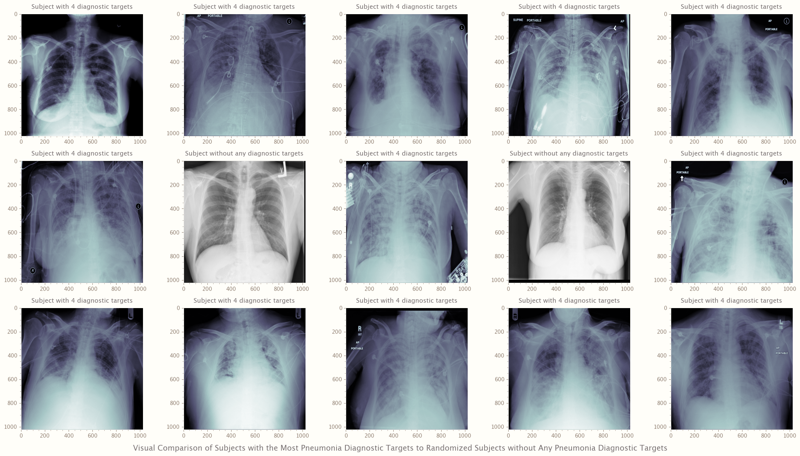

In [13]:
def image_display(image, ax, title, cmap):
    ax.imshow(image, cmap)
    ax.grid(False)
    ax.set_title(title, loc="center", pad=10)
    x_ticks = list(range(0, image.shape[1], 200))
    y_ticks = list(range(0, image.shape[0], 200))
    ax.set(xticks=x_ticks, xticklabels=x_ticks, yticks=y_ticks, yticklabels=y_ticks)
    ax.set_xlim(left=0)
    ax.set_ylim(top=0)
    ax.minorticks_on()
    return ax


ROOT_PATH = Path(
    "../Datasets/Kaggle - RSNA Pneumonia Detection Challenge/stage_2_train_images/"
)

fig, axs = plt.subplots(3, 5, figsize=(figure_size[0] / 3 * 4, figure_size[1] / 3 * 4))

c = 0
for i, ax in enumerate(axs.flat):
    untargeted = iter(labels.loc[labels["Target"] == 0].sample(2)["patientId"])
    if i not in [6, 8]:
        patient_id = most_tagged_IDs.patientId.iloc[c]
        dcm_path = ROOT_PATH / patient_id
        # `PurePath.with_suffix` returns the new path with the changed suffix

        # Note that if the original path does not have a suffix, the new suffix is added;
        # if the suffix is an empty string, the original suffix is removed
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        targets = most_tagged_IDs["Target"].iloc[c]
        title = f"Subject with {targets} diagnostic targets"
        image_display(dcm, ax, title, "bone")
        c += 1
    else:
        patient_id = next(untargeted)
        dcm_path = ROOT_PATH / patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        title = "Subject without any diagnostic targets"
        image_display(dcm, ax, title, "gray")

fig.suptitle(
    "Visual Comparison of Subjects with the Most Pneumonia Diagnostic Targets to "
    "Randomized Subjects without Any Pneumonia Diagnostic Targets",
    fontsize="x-large",
    x=0.5,
    y=0,
)

plt.tight_layout()
plt.show()

### <a id='toc5_1_2_'></a>[Reading and Effective Storage of DICOM Files](#toc0_)


In [14]:
SAVE_PATH = Path("processed/")

sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    # Bits Stored (0028,0101) indicates number of bits stored for each pixel sample,
    # noting that each sample shall have the same number of bits stored
    bits_stored = pydicom.read_file(dcm_path).BitsStored
    dcm = pydicom.read_file(dcm_path).pixel_array / (np.power(2, bits_stored) - 1)
    # Resize the original image to 224 x 224 to reduce the processing load on the deep learning
    # model

    # When storing an image, it is converted to float16 to reduce the amount of space used
    # because, in computing, half-precision (sometimes referred to as FP16 or float16) is a
    # binary floating-point computer number format that takes up two bytes in computer memory
    # and is used to represent numbers in small amounts of storage space and with low accuracy
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]

    # Retrieve the corresponding label for each image
    label = labels.Target.iloc[c]
    # Split the training image set into a training subset and a validation subset
    train_or_val = "train" if c < 24000 else "val"
    # Divide the training subset and validation subset into labeled subsets based on labels,
    # respectively
    current_save_path = ROOT_PATH / SAVE_PATH / train_or_val / str(label)
    # `Path.mkdir` will create a new directory under the given path with two frequently used
    # parameters `parents` and `exists_ok`

    # If `parents` is True, missing parents for the path are created as needed; however, if
    # `parents` is False (the default is False), the missing parent raises `FileNotFoundError`
    # exception

    # If `exist_ok` is False (the default is False), the `FileExistsError` exception is thrown
    # if the destination directory already exists; if `exist_ok` is True, the `FileExistsError`
    # exception is ignored if the last path component is not an existing non-directory file
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(file=current_save_path / patient_id, arr=dcm_array)

    # Compute dataset statistics using only the training subset
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))

tabulation = Form_Generator()
tabulation.heading_printer(
    "Effective storing of DICOM files and calculating of statistics"
)

statements = [
    """
SAVE_PATH = Path("processed/")

sums = 0
sums_squared = 0

for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    bits_stored = pydicom.read_file(dcm_path).BitsStored
    dcm = pydicom.read_file(dcm_path).pixel_array / (np.power(2, bits_stored) - 1)
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]

    label = labels.Target.iloc[c]
    train_or_val = "train" if c < 24000 else "val"
    current_save_path = ROOT_PATH / SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(file=current_save_path / patient_id, arr=dcm_array)

    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))
"""
]
tabulation.statement_generator(statements)

variables = ["bits_stored", "normalizer", "sums", "sums_squared", "mean", "std"]
values = [
    str(bits_stored),
    str(normalizer),
    str(sums),
    str(sums_squared),
    str(mean),
    str(std),
]
tabulation.variable_generator(variables, values)

  0%|          | 0/26684 [00:00<?, ?it/s]

Effective storing of DICOM files and calculating of statistics

    +----------------------------------------------------------+
    | Statement                                                |
    +----------------------------------------------------------+
    | SAVE_PATH = Path("processed/")                           |
    |                                                          |
    | sums = 0                                                 |
    | sums_squared = 0                                         |
    |                                                          |
    | for c, patient_id in enumerate(tqdm(labels.patientId)):  |
    |     dcm_path = ROOT_PATH / patient_id                    |
    |     dcm_path = dcm_path.with_suffix(".dcm")              |
    |     bits_stored = pydicom.read_file(dcm_path).BitsStored |
    |     dcm = pydicom.read_file(dcm_path).pixel_array /      |
    |     (np.power(2, bits_stored) - 1)                       |
    |     dcm_array = cv2.

## <a id='toc5_2_'></a>[Train - Part One - Data Loading](#toc0_)

In [31]:
# `transforms.Compose` composes several transforms together
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        # `transforms.Normalize` normalizes the tensor image with mean and standard deviation
        transforms.Normalize(mean, std),
        #   # Data Augmentation
        transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1)),
    ]
)

val_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)


tabulation = Form_Generator()
tabulation.heading_printer("Definition of data transformation and data augmentation pipelines ")

statements = [
    """
train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1)),
    ]
)

val_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)
"""
]
tabulation.statement_generator(statements, 12)

variables = ["train_transforms", "val_transforms"]
values = [str(train_transforms), str(val_transforms)]
tabulation.variable_generator(variables, values, 4)

expressions = [
    "len(train_transforms)",
    "len(val_transforms)",
]
results = [
    str(type(train_transforms)),
    str(type(val_transforms)),
]
# tabulation.expression_generator(expressions, results, 1)



    +--------------------------------------------------------+
    | Statement                                              |
    +--------------------------------------------------------+
    | train_transforms = transforms.Compose(                 |
    |     [                                                  |
    |         transforms.ToTensor(),                         |
    |         transforms.Normalize(mean, std),               |
    |         transforms.RandomAffine(degrees=(-5, 5),       |
    |             translate=(0, 0.05), scale=(0.9, 1.1)),    |
    |         transforms.RandomResizedCrop((224, 224),       |
    |             scale=(0.35, 1)),                          |
    |     ]                                                  |
    | )                                                      |
    |                                                        |
    | val_transforms = transforms.Compose(                   |
    |     [transforms.ToTensor(), transforms.Normaliz

In [33]:
type(val_transforms)

torchvision.transforms.transforms.Compose

In [17]:
def load_file(path):
    return np.load(path).astype(np.float32)


tabulation = Form_Generator()
tabulation.heading_printer("")

definitions = [
    """

"""
]
tabulation.definition_generator(definitions)

statements = [
    """

"""
]
tabulation.statement_generator(statements)

variables = [""]
values = [str(0)]
tabulation.variable_generator(variables, values)



    +------------+
    | Definition |
    +------------+
    |            |
    +------------+
    +-----------+
    | Statement |
    +-----------+
    |           |
    +-----------+
    +----------+-------+
    | Variable | Value |
    +----------+-------+
    |          | 0     |
    +----------+-------+


In [ ]:
train_dataset = datasets.DatasetFolder(
    f"{ROOT_PATH}/{SAVE_PATH}/train/",
    loader=load_file,
    extensions="npy",
    transform=train_transforms,
)

val_dataset = datasets.DatasetFolder(
    f"{ROOT_PATH}/{SAVE_PATH}/val/",
    loader=load_file,
    extensions="npy",
    transform=val_transforms,
)